In [1]:
import gensim
import numpy as np
import spacy
from spacy import displacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import sklearn
#!pip install pyLDAvis
#python -m spacy download en_core_web_sm

Using TensorFlow backend.


In [2]:
import warnings
import os
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [3]:
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'
text = open(lee_train_file).read()

In [4]:
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm") 

For safe measure, let's add some stopwords. It's a newspaper corpus, so it is likely we will be coming across variations of 'said' and 'Mister' which will not really add any value to the topic models.


In [5]:
my_stop_words = [u'say', u'\'s', u'mr', u'be', u'said', u'says', u'saying', 'today']
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [6]:
doc = nlp(text.lower())

In [7]:
doc

hundreds of people have been forced to vacate their homes in the southern highlands of new south wales as strong winds today pushed a huge bushfire towards the town of hill top. a new blaze near goulburn, south-west of sydney, has forced the closure of the hume highway. at about 4:00pm aedt, a marked deterioration in the weather as a storm cell moved east across the blue mountains forced authorities to make a decision to evacuate people from homes in outlying streets at hill top in the new south wales southern highlands. an estimated 500 residents have left their homes for nearby mittagong. the new south wales rural fire service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around hill top are optimistic of defending all properties. as more than 100 blazes burn on new year's eve in new south wales, fire crews have been called to new fire at gunning, south of goulburn. while few details are available at this

In [8]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [9]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


#### NER-Tagging

In [10]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


In [11]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [12]:
#Great for visualization
displacy.render(sent, style='ent', jupyter=True)

In [13]:
displacy.render(doc, style='ent', jupyter=True)

#### Dependency Parsing

In [14]:
for chunk in sent.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
          chunk.root.head.text)


Tom Tom nsubj went
IKEA IKEA pobj to
those delicious Swedish meatballs meatballs pobj of


In [15]:
for token in sent:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])


Tom nsubj went VERB []
went ROOT went VERB [Tom, to, get, .]
to prep went VERB [IKEA]
IKEA pobj to ADP []
to aux get AUX []
get advcl went VERB [to, some]
some dobj get AUX [of]
of prep some DET [meatballs]
those det meatballs NOUN []
delicious amod meatballs NOUN []
Swedish amod meatballs NOUN []
meatballs pobj of ADP [those, delicious, Swedish]
. punct went VERB []


In [150]:
displacy.render(sent, style='dep', jupyter=True)

In [17]:
# we add some words to the stop word list
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and w.text != 'I':
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

In [18]:
texts

[['hundred',
  'people',
  'force',
  'vacate',
  'home',
  'southern',
  'highland',
  'new',
  'south',
  'wales',
  'strong',
  'wind',
  'push',
  'huge',
  'bushfire',
  'town',
  'hill',
  'new',
  'blaze',
  'near',
  'goulburn',
  'south',
  'west',
  'sydney',
  'force',
  'closure',
  'hume',
  'highway',
  '4:00pm',
  'aedt',
  'marked',
  'deterioration',
  'weather',
  'storm',
  'cell',
  'move',
  'east',
  'blue',
  'mountain',
  'force',
  'authority',
  'decision',
  'evacuate',
  'people',
  'home',
  'outlying',
  'street',
  'hill',
  'new',
  'south',
  'wales',
  'southern',
  'highland',
  'estimate',
  'resident',
  'leave',
  'home',
  'nearby',
  'mittagong',
  'new',
  'south',
  'wales',
  'rural',
  'fire',
  'service',
  'weather',
  'condition',
  'cause',
  'fire',
  'burn',
  'finger',
  'formation',
  'ease',
  'fire',
  'unit',
  'hill',
  'optimistic',
  'defend',
  'property',
  'blaze',
  'burn',
  'new',
  'year',
  'eve',
  'new',
  'south',
  '

And this is the magic of spaCy - just like that, we've managed to get rid of stopwords, punctauation markers, and added the lemmatized word. 

Sometimes topic models make more sense when 'New' and 'York' are treated as 'New_York' - we can do this by creating a bigram model and modifying our corpus accordingly.

In [19]:
bigram = gensim.models.Phrases(texts)

In [20]:
texts = [bigram[line] for line in texts]

In [21]:
texts[0]

['hundred',
 'people',
 'force',
 'vacate',
 'home',
 'southern',
 'highland',
 'new_south',
 'wales',
 'strong',
 'wind',
 'push',
 'huge',
 'bushfire',
 'town',
 'hill',
 'new',
 'blaze',
 'near',
 'goulburn',
 'south',
 'west',
 'sydney',
 'force',
 'closure',
 'hume',
 'highway',
 '4:00pm',
 'aedt',
 'marked',
 'deterioration',
 'weather',
 'storm',
 'cell',
 'move',
 'east',
 'blue_mountain',
 'force',
 'authority',
 'decision',
 'evacuate',
 'people',
 'home',
 'outlying',
 'street',
 'hill',
 'new_south',
 'wales',
 'southern',
 'highland',
 'estimate',
 'resident',
 'leave',
 'home',
 'nearby',
 'mittagong',
 'new_south',
 'wales',
 'rural_fire',
 'service',
 'weather_condition',
 'cause',
 'fire_burn',
 'finger',
 'formation',
 'ease',
 'fire',
 'unit',
 'hill',
 'optimistic',
 'defend',
 'property',
 'blaze',
 'burn',
 'new',
 'year',
 'eve',
 'new_south',
 'wales',
 'fire',
 'crew',
 'call',
 'new',
 'fire',
 'gunning',
 'south',
 'goulburn',
 'detail',
 'available',
 'stage

In [22]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [26]:
dictionary[19]

'cranebrook'

In [27]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 3),
 (34, 1),
 (35, 1),
 (36, 5),
 (37, 2),
 (38, 1),
 (39, 3),
 (40, 1),
 (41, 1),
 (42, 2),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 2),
 (47, 2),
 (48, 3),
 (49, 3),
 (50, 1),
 (51, 2),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 2),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 4),
 (67, 4),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 2),
 (73, 1),
 (74, 1),
 (75, 2),
 (76, 1),
 (77, 3),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 2),
 (85, 2),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 3),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 4),
 (99, 1),
 (100, 1),

In [75]:
#Converting the corpus to tfidf
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


## Topic Modelling

In [39]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

W0503 01:45:39.070909 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


In [40]:
ldamodel.show_topics()

[(0,
  '0.006*"people" + 0.005*"force" + 0.005*"area" + 0.004*"work" + 0.004*"service" + 0.004*"australian" + 0.003*"new" + 0.003*"afghanistan" + 0.003*"year" + 0.003*"police"'),
 (1,
  '0.007*"australia" + 0.006*"australian" + 0.005*"people" + 0.005*"company" + 0.004*"force" + 0.004*"government" + 0.004*"afghanistan" + 0.004*"year" + 0.004*"union" + 0.003*"month"'),
 (2,
  '0.005*"day" + 0.005*"australian" + 0.004*"fire" + 0.004*"qantas" + 0.004*"afghanistan" + 0.004*"government" + 0.004*"force" + 0.003*"area" + 0.003*"official" + 0.003*"australia"'),
 (3,
  '0.007*"israeli" + 0.007*"palestinian" + 0.005*"arafat" + 0.005*"day" + 0.005*"hamas" + 0.004*"attack" + 0.004*"australian" + 0.004*"police" + 0.004*"area" + 0.004*"group"'),
 (4,
  '0.008*"australia" + 0.007*"australian" + 0.006*"people" + 0.005*"man" + 0.004*"day" + 0.004*"attack" + 0.004*"force" + 0.004*"government" + 0.004*"group" + 0.003*"police"'),
 (5,
  '0.005*"year" + 0.004*"road" + 0.004*"space" + 0.004*"new" + 0.004*"ne

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
  
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,minimum_probability=0)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [79]:
from gensim.models.coherencemodel import CoherenceModel
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=texts, limit=35, start=2, step=2)


W0503 02:42:32.107452 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
W0503 02:42:34.870027 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
W0503 02:42:38.221280 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
W0503 02:42:40.891087 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
W0503 02:42:43.809946 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
W0503 02:42:46.890757 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or itera

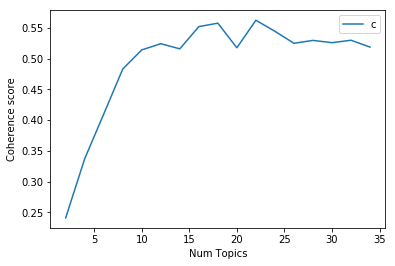

In [80]:
# Show graph
import matplotlib.pyplot as plt
%matplotlib inline
limit=35; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
#Either do this or use HDPmodel
#Or use PyLdavis for visualization and clustering the topics

In [109]:
from gensim.models import HdpModel
hdpmodel_tfidf = HdpModel(corpus=corpus_tfidf, id2word=dictionary)
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary,)

W0503 03:22:16.714233 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.723013 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.725581 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.728932 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.735652 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.744588 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.747568 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.751301 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.753862 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.757086 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.759757 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.763086 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:16.766091 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:

W0503 03:22:17.724792 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.779002 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.830323 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.854304 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.862468 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.866833 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.870025 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.873180 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.878875 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.902015 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.907000 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.912307 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:17.925037 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:

W0503 03:22:19.235168 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.241263 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.247749 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.256758 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.298887 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.307224 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.311348 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.313604 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.322269 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.349627 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.361119 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.364415 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:19.371736 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:

W0503 03:22:20.538290 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.542090 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.546874 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.551378 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.563557 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.570246 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.608614 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.612805 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.658044 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.660908 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.680085 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.712603 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:20.722704 4491175360 hdpmodel.py:676] likelihood is decreasing!
W0503 03:22:

In [110]:
ldamodel_tfidf = LdaModel(corpus=corpus_tfidf, num_topics=10, id2word=dictionary,minimum_probability=0) #set minimum prob to zero

W0503 03:22:38.017593 4491175360 ldamodel.py:934] too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


In [111]:
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
hdptopics_tfidf = [[word for word, prob in topic] for topicid, topic in hdpmodel_tfidf.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
ldatopics_tfidf = [[word for word, prob in topic] for topicid, topic in ldamodel_tfidf.show_topics(formatted=False)]

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary,coherence='c_v').get_coherence()
hdp_coherence_tfidf = CoherenceModel(topics=hdptopics_tfidf[:10], texts=texts, dictionary=dictionary,coherence='c_v').get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
lda_coherence_tfidf = CoherenceModel(topics=ldatopics_tfidf, texts=texts, dictionary=dictionary,coherence='c_v').get_coherence()

In [112]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

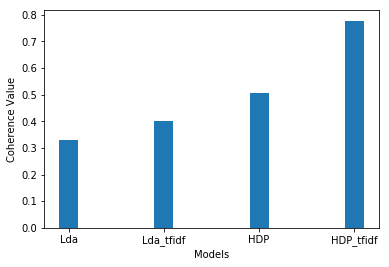

In [113]:
evaluate_bar_graph([lda_coherence, lda_coherence_tfidf, hdp_coherence, hdp_coherence_tfidf],
                   ['Lda', 'Lda_tfidf', 'HDP','HDP_tfidf'])

In [114]:
lda_corpus = ldamodel_tfidf[corpus_tfidf]

In [115]:
from itertools import chain
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)


#scores = []
#for doc in lda_corpus
 #   for topic in doc:
  #      for topic_id, score in topic:
   #         scores.append(score)
#threshold = sum(scores)/len(scores)

In [118]:
doc

hundreds of people have been forced to vacate their homes in the southern highlands of new south wales as strong winds today pushed a huge bushfire towards the town of hill top. a new blaze near goulburn, south-west of sydney, has forced the closure of the hume highway. at about 4:00pm aedt, a marked deterioration in the weather as a storm cell moved east across the blue mountains forced authorities to make a decision to evacuate people from homes in outlying streets at hill top in the new south wales southern highlands. an estimated 500 residents have left their homes for nearby mittagong. the new south wales rural fire service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around hill top are optimistic of defending all properties. as more than 100 blazes burn on new year's eve in new south wales, fire crews have been called to new fire at gunning, south of goulburn. while few details are available at this

In [119]:

cluster1 = [j for i,j in zip(lda_corpus,texts) if i[0][1] > threshold] #here doc should be the sentence unprocessed
#cluster2, cluster3....
#cluster2 = [j for i,j in zip(lda_corpus,documents) if i[1][1] > threshold]
#cluster3 = [j for i,j in zip(lda_corpus,documents) if i[2][1] > threshold]
#print(cluster1)

[['federal_government', 'new', 'national', 'fuel', 'quality', 'standard', 'petrol', 'diesel', 'greatly', 'reduce', 'toxic', 'emission', 'car', 'truck', 'federal', 'minister', 'environment', 'david', 'kemp', 'state', 'territory', 'inspector', 'conduct', 'random', 'fuel', 'sampling', 'refinery', 'distributor', 'terminal', 'petrol', 'station', 'country', 'new', 'law', 'introduce', 'cut', 'pollution', 'vehicle', 'hope', 'lead', 'reduction', 'respiratory', 'illness', 'community', 'lead', 'petrol', 'prohibit', 'new', 'law', 'car', 'build', 'prior', 'use', 'lead', 'petrol', 'require', 'use', 'lead', 'replacement', 'petrol', 'kemp', 'expect', 'emission', 'major', 'pollutant', 'benzene', 'carbon', 'monoxide', 'reduce', 'cent', 'emission', 'pollutant', 'reduce', 'cent'], ['americans', 'fear', 'airplane', 'security', 'continue', 'increase', 'man', 'separate', 'flight', 'load', 'gun', 'carry', 'luggage', 'man', 'finally', 'stop', 'board', 'plane', 'memphis', 'man', 'travel', 'florida', 'atlanta', 

In [136]:
import pandas as pd
df=pd.DataFrame({'Sentences':cluster1,'Topic':1})

In [138]:
df.head()

Sentences  Topic
0  [federal_government, new, national, fuel, qual...      1
1  [americans, fear, airplane, security, continue...      1
2  [new_york, mayor, rudolph, giuliani, bade, far...      1
3  [total, yacht, retire, sydney_hobart, yacht_ra...      1
4  [man, accuse, try, blow, american, airlines, f...      1

This is a great way to get a view of what words end up appearing in our documents, and what kind of document topics might be present. For more details, such as the other topic models which Gensim provides, as well as ways to measure topic coherence (performance), and visualisation, the topic modelling notebook in the same directory will serve as a good resource.

In [139]:
cluster2 = [j for i,j in zip(lda_corpus,texts) if i[1][1] > threshold]

In [140]:
df2=pd.DataFrame({'Sentences':cluster2,'Topic':2})

In [141]:
df2.head()

Sentences  Topic
0  [hour, crucial, firefighter, alert, blue_mount...      2
1  [earthquake, measure, richter, scale, shake, p...      2
2  [new_south, wales, firefighter, hope, light, w...      2
3  [rafter, raise, alarm, party, sweep, franklin,...      2
4  [police, interview, 21-year, old, man, steal, ...      2

In [145]:
df_merge=pd.concat([df,df2])

In [147]:
df_merge.sample(10)

Sentences  Topic
26  [royal_commission, collapse, insurance, giant,...      2
11  [fire, damage, st, john, divine, cathedral, ne...      2
35  [israeli, force, launch, attack, key, palestin...      2
9   [woomera_detention, centre, outback, south, au...      1
41  [university, canberra, academic, proposal, rep...      2
26  [afghan, opposition, leader, meet, germany, re...      1
31  [reserve_bank, governor, ian, macfarlane, conf...      2
28  [israeli, soldier, shoot_dead, palestinians, w...      1
9   [northern_territory, coroner, find, aboriginal...      2
33  [afl, time, lead, goalkicker, tony, lockett, d...      2

In [148]:
import pyLDAvis.gensim
#Visualize the topic models
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel_tfidf, corpus_tfidf, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.006803  0.010445       1        1  13.572186
1      0.015216  0.020265       2        1  12.725538
7     -0.025072 -0.005569       3        1  12.709400
5      0.013564 -0.022944       4        1  10.055120
0      0.009524 -0.006394       5        1   9.508677
6     -0.008521  0.002791       6        1   8.862530
8     -0.000931 -0.008456       7        1   8.674542
4      0.001243  0.006381       8        1   8.531986
2      0.000859  0.000540       9        1   7.732520
9      0.000920  0.002940      10        1   7.627506, topic_info=     Category      Freq              Term     Total  loglift  logprob
term                                                                 
2055  Default  0.000000           economy  0.000000  30.0000  30.0000
88    Default  0.000000             storm  0.000000  29.0000  29.0000
3302  Default  1.000000            qantas  1.000000  28.0000  28.0000
126   Default  0.000000             india  0.000000  27.0000  27.0000
2225  Default  0.000000  governor_general  0.000000  26.0000  26.0000
187   Default  0.000000              road  0.000000  25.0000  25.0000
1266  Default  0.000000              rate  0.000000  24.0000  24.0000
329   Default  0.000000             nauru  0.000000  23.0000  23.0000
4175  Default  0.000000              drug  0.000000  22.0000  22.0000
3375  Default  0.000000             spill  0.000000  21.0000  21.0000
2634  Default  0.000000      senator_hill  0.000000  20.0000  20.0000
2292  Default  0.000000          phillips  0.000000  19.0000  19.0000
965   Default  0.000000          williams  0.000000  18.0000  18.0000
176   Default  0.000000          fatality  0.000000  17.0000  17.0000
1407  Default  1.000000          al_qaeda  1.000000  16.0000  16.0000
1845  Default  0.000000             guide  0.000000  15.0000  15.0000
127   Default  0.000000            indian  0.000000  14.0000  14.0000
1197  Default  0.000000              reid  0.000000  13.0000  13.0000
3406  Default  0.000000             space  0.000000  12.0000  12.0000
3972  Default  0.000000           lockett  0.000000  11.0000  11.0000
342   Default  0.000000           taliban  0.000000  10.0000  10.0000
479   Default  0.000000              line  0.000000   9.0000   9.0000
4580  Default  0.000000            casino  0.000000   8.0000   8.0000
1967  Default  0.000000        centrelink  0.000000   7.0000   7.0000
1253  Default  0.000000            farmer  0.000000   6.0000   6.0000
2672  Default  0.000000           refugee  0.000000   5.0000   5.0000
4410  Default  0.000000       lung_cancer  0.000000   4.0000   4.0000
2249  Default  0.000000        east_timor  0.000000   3.0000   3.0000
1572  Default  0.000000            wicket  0.000000   2.0000   2.0000
1982  Default  0.000000           project  0.000000   1.0000   1.0000
...       ...       ...               ...       ...      ...      ...
3326  Topic10  0.078145             ntini  0.333739   1.1216  -7.6521
3687  Topic10  0.089468              join  0.385396   1.1130  -7.5168
3372  Topic10  0.076668           phillip  0.332262   1.1070  -7.6712
4130  Topic10  0.129225           friedli  0.563883   1.1001  -7.1491
2249  Topic10  0.125377        east_timor  0.551162   1.0927  -7.1794
2026  Topic10  0.134377          question  0.591038   1.0922  -7.1100
746   Topic10  0.079548            repeat  0.350037   1.0917  -7.6343
3813  Topic10  0.081978               bob  0.375488   1.0516  -7.6042
2965  Topic10  0.137069              asio  0.635117   1.0401  -7.0902
2966  Topic10  0.109821  attorney_general  0.507993   1.0418  -7.3118
3095  Topic10  0.105863         tailender  0.491968   1.0371  -7.3485
1701  Topic10  0.106692            virgin  0.502492   1.0238  -7.3407
898   Topic10  0.202205              test  1.179331   0.8100  -6.7014
2743  Topic10  0.130992          training  0.677537   0.9301  -7.1356
992   Topic10  0.20